## 11-1 들어가며
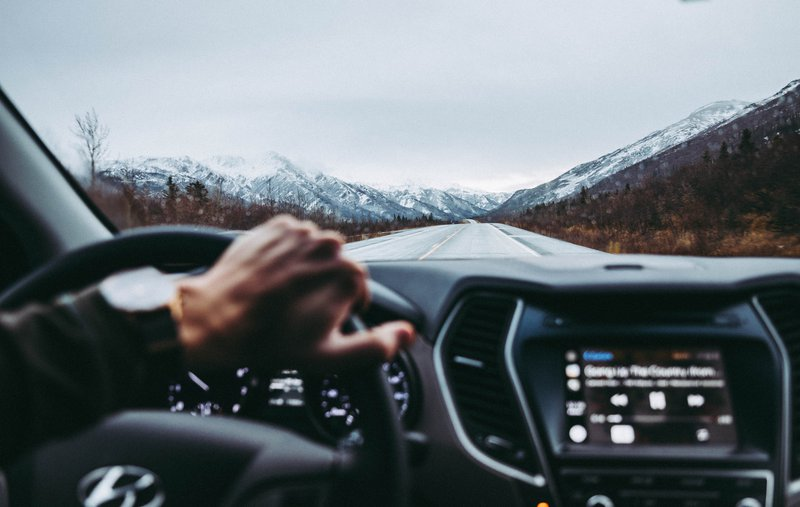

이번 시간에는 object detection 모델을 통해 주변에 다른 차나 사람이 가까이 있는지 확인한 후 멈출 수 있는 자율주행 시스템을 만들어 보겠습니다. 하지만 자율주행 시스템은 아직 완전하지 않기 때문에, 위험한 상황에서는 운전자가 직접 운전할 수 있도록 하거나 판단이 어려운 상황에서는 멈추도록 설계됩니다. 우리도 같은 구조를 가진 미니 자율주행 보조장치를 만들어 볼 겁니다.

## 11-2 자율주행 보조장치 (1)KITTI 데이터셋
이번 시간에 만들어 볼 자율주행 보조장치는 카메라에 사람이 탐지되었을 때, 그리고 차가 가까워져서 탐지된 크기가 일정 크기 이상일 때를 판단해야 합니다.

자율주행 보조장치 object detection 요구사항
1. 사람이 카메라에 감지되면 정지
2. 차량이 일정 크기 이상으로 감지되면 정지

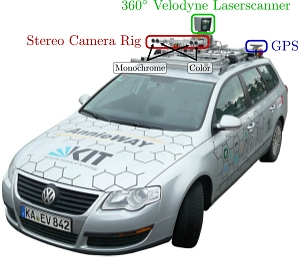

이번 시간에는 tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용해보겠습니다. KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D object detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.
- cvlibs에서 제공하는 KITTI 데이터셋 (https://www.cvlibs.net/datasets/kitti/)

먼저 필요한 라이브러리를 불러 오겠습니다.

In [ ]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

print('슝=3')
%pwd

아래 코드를 통해서 KITTI 데이터셋을 다운로드해 주세요. 30-40분 정도 걸립니다.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

다운로드한 KITTI 데이터셋을 tfds.show_examples를 통해 보도록 합시다. 우리가 일반적으로 보는 사진보다 광각으로 촬영되어 다양한 각도의 물체를 확인할 수 있습니다.

In [ ]:
_ = tfds.show_examples(ds_train, ds_info)

데이터 다운로드 시 담아둔 ds_info에서는 불러온 데이터셋의 정보를 확인할 수 있습니다. 오늘 사용할 데이터셋은 6,347개의 학습 데이터(training data), 711개의 평가용 데이터(test data), 423개의 검증용 데이터(validation data)로 구성되어 있습니다. 라벨에는 alpha, bbox, dimensions, location, occluded, rotation_y, truncated 등의 정보가 있습니다.

In [ ]:
ds_info

## 11-3 자율주행 보조장치 (2)데이터 직접 확인하기
이번에는 데이터셋을 직접 확인하는 시간을 갖도록 하겠습니다. ds_train.take(1)을 통해서 데이터셋을 하나씩 뽑아볼 수 있는 sample을 얻을 수 있습니다. 이렇게 뽑은 데이터에는 image 등의 정보가 포함되어 있습니다.

눈으로 확인해서 학습에 사용할 데이터를 직접 이해해 봅시다.

In [ ]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

# img = Image.fromarray(image.numpy())
plt.imshow(image)
plt.show()

이미지와 라벨을 얻는 방법을 알게 되었습니다. 그렇다면 이렇게 얻은 이미지의 바운딩 박스(bounding box, bbox)를 확인하기 위해서는 어떻게 해야 할까요?

아래는 KITTI에서 제공하는 데이터셋에 대한 설명입니다.

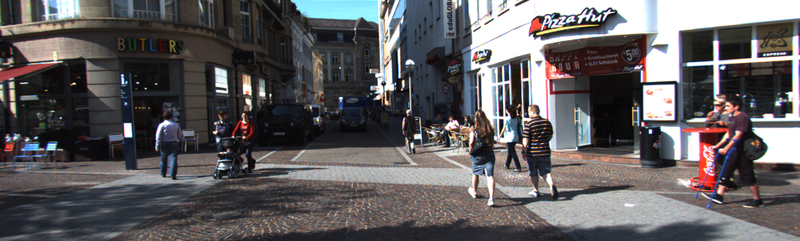
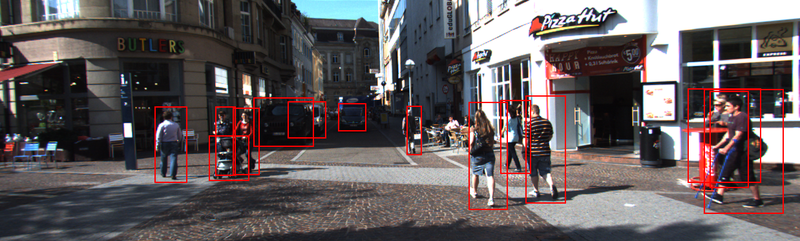

위 설명과 예시 이미지를 참고하셔서 이미지 위에 바운딩 박스를 그려서 시각화해 보세요!

Pillow 라이브러리의 ImageDraw(https://pillow.readthedocs.io/en/stable/reference/ImageDraw.html) 모듈을 참고하세요.

In [ ]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 11-4 RetinaNet
- Focal Loss for Dense Object Detection (https://arxiv.org/abs/1708.02002)

RetinaNet은 Focal Loss for Dense Object Detection 논문을 통해 공개된 detection 모델입니다.

1-stage detector 모델인 YOLO와 SSD는 2-stage detector인 Faster-RCNN 등보다 속도는 빠르지만 성능이 낮은 문제를 가지고 있었습니다. 이를 해결하기 위해서 RetinaNet에서는 focal loss와 FPN(Feature Pyramid Network) 를 적용한 네트워크를 사용합니다.

### Focal Loss
물체를 배경보다 더 잘 학습하자 == 물체인 경우 Loss를 작게 만들자

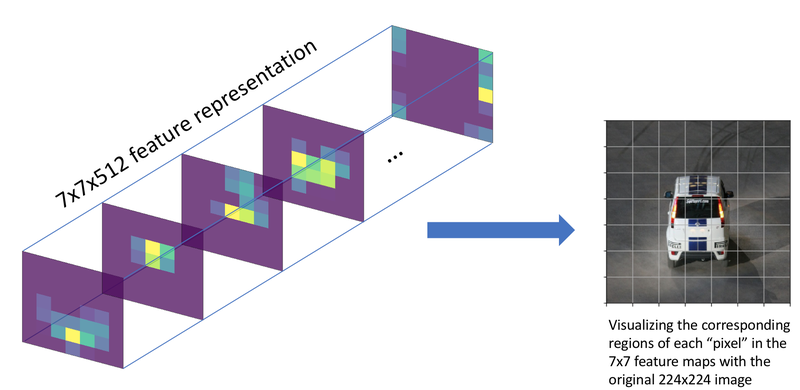

Focal loss는 기존의 1-stage detection 모델들(YOLO, SSD)이 물체 전경과 배경을 담고 있는 모든 그리드(grid)에 대해 한 번에 학습됨으로 인해서 생기는 클래스 간의 불균형을 해결하고자 도입되었습니다. 여기서 그리드(grid)와 픽셀(pixel)이 혼란스러울 수 있겠는데, 위 그림 왼쪽 7x7 feature level에서는 한 픽셀이고, 오른쪽의 image level(자동차 사진)에서 보이는 그리드는 각 픽셀의 receptive field입니다.

그림에서 보이는 것처럼 우리가 사용하는 이미지는 물체보다는 많은 배경을 학습하게 됩니다. 논문에서는 이를 해결하기 위해서 Loss를 개선하여 정확도를 높였습니다.
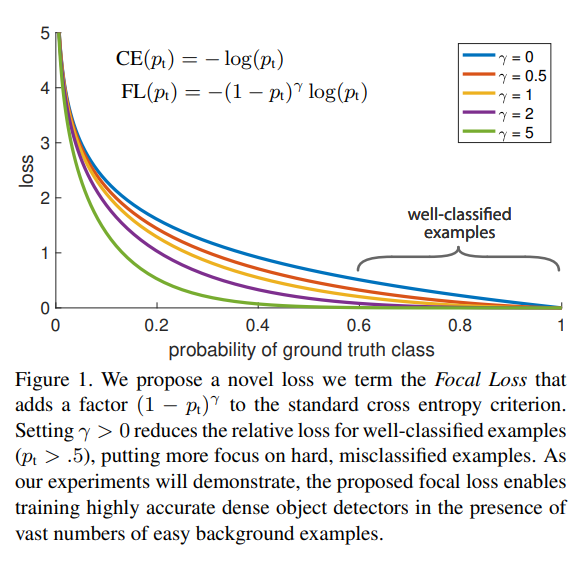

Focal loss는 우리가 많이 사용해왔던 교차 엔트로피를 기반으로 만들어졌습니다. 위 그림을 보면 Focal loss는 그저 교차 엔트로피 CE(p_t)의 앞단에 간단히 (1−p_t)^r라는 modulating factor를 붙여주었습니다.

교차 엔트로피의 개형을 보면 ground truth class에 대한 확률이 높으면 잘 분류된 것으로 판단되므로 손실이 줄어드는 것을 볼 수 있습니다. 하지만 확률이 1에 매우 가깝지 않은 이상 상당히 큰 손실로 이어지는데요.

이 상황은 물체 검출 모델을 학습시키는 과정에서 문제가 될 수 있습니다. 대부분의 이미지에서는 물체보다 배경이 많습니다. 따라서 이미지는 극단적으로 배경의 class가 많은 class imbalanced data라고 할 수 있습니다. 이렇게 너무 많은 배경 class에 압도되지 않도록 modulating factor로 손실을 조절해줍니다.
γ를 0으로 설정하면 modulating factor (1−p)γ가 1이 되어 일반적인 교차 엔트로피가 되고 γ가 커질수록 modulating이 강하게 적용되는 것을 확인할 수 있습니다.

### FPN(Feature Pyramid Network)
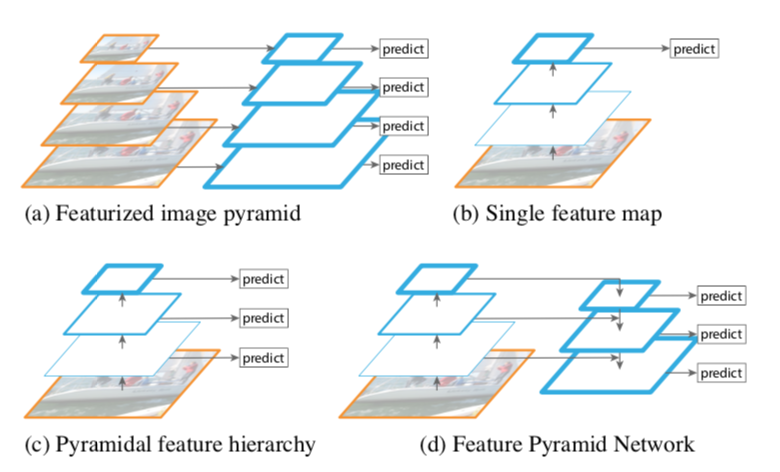

FPN은 특성을 피라미드처럼 쌓아서 사용하는 방식입니다. CNN 백본 네트워크에서는 다양한 레이어의 결과값을 특성 맵(feature map)으로 사용할 수 있습니다. 이때 컨볼루션 연산은 커널을 통해 일정한 영역을 보고 몇 개의 숫자로 요약해 내기 때문에, 입력 이미지를 기준으로 생각하면 입력 이미지와 먼 모델의 뒷쪽의 특성 맵일수록 하나의 "셀(cell)"이 넓은 이미지 영역의 정보를 담고 있고, 입력 이미지와 가까운 앞쪽 레이어의 특성 맵일수록 좁은 범위의 정보를 담고 있습니다. 이를 receptive field라고 합니다. 레이어가 깊어질 수록 pooling을 거쳐 넓은 범위의 정보(receptive field)를 갖게 되는 것입니다.
FPN은 백본의 여러 레이어를 한꺼번에 쓰겠다라는데에 의의가 있습니다. SSD가 각 레이어의 특성 맵에서 다양한 크기에 대한 결과를 얻는 방식을 취했다면 RetinaNet에서는 receptive field가 넓은 뒷쪽의 특성 맵을 upsampling(확대)하여 앞단의 특성 맵과 더해서 사용했습니다. 레이어가 깊어질수록 feature map의 w, h방향의 receptive field가 넓어지는 것인데, 넓게 보는 것과 좁게 보는 것을 같이 쓰겠다는 목적인 거죠.
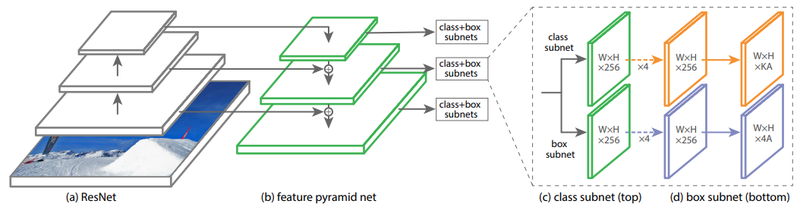

위 그림은 RetinaNet 논문에서 FPN 구조가 어떻게 적용되었는지를 설명하는 그림입니다. RetinaNet에서는 FPN을 통해 P_3부터 P_7까지의 pyramid level을 생성해 사용합니다. 각 pyramid level은 256개의 채널로 이루어지게 됩니다. 이를 통해 Classification Subnet과 Box Regression Subnet 2개의 Subnet을 구성하게 되는데, Anchor 갯수를 A라고 하면 최종적으로 Classification Subnet은 K개 class에 대해 KA개 채널을, Box Regression Subnet은 4A개 채널을 사용하게 됩니다.

## 11-5 데이터 준비
### 데이터 파이프 라인
먼저 주어진 KITTI 데이터를 학습에 맞는 형태로 바꾸어 주어야 합니다. 이때 사용할 데이터 파이프라인을 구축합니다.

데이터 파이프라인은 총 4단계로 이루어집니다.

1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

독립적인 함수를 각각 작성합니다.

In [ ]:
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

print('슝=3')

In [ ]:
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

print('슝=3')

이미지 크기를 바꿀 때는 고려할 점이 있습니다. 이미지의 비율은 그대로 유지되어야 하고, 이미지의 최대/최소 크기도 제한해야 하거든요. 또 이미지의 크기를 바꾼 후에도 최종적으로 모델에 입력되는 이미지의 크기는 stride의 배수가 되도록 만들 거예요.

예를 들어 600x720 크기의 이미지가 있다면 800x960 크기로 바꿀 수 있습니다. 여기에 stride를 128로 놓아 800x960 크기의 이미지에 패딩을 더해 896x1024 크기의 이미지로 모델에 입력하겠다는 이야깁니다. 모델에 입력되는 이미지에는 검정 테두리가 있겠군요!

실제로 입력할 이미지를 어떻게 바꿀지는 min_side, max_side, min_side_range, stride등에 의해 결정돼요. 그리고 학습이 완료된 모델을 사용할 때는 입력할 이미지를 다양한 크기로 바꿀 필요는 없으니 분기처리를 해줍니다.

In [ ]:
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

print('슝=3')

In [ ]:
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

print('슝=3')

이제 준비된 함수들을 연결해 줍니다.

In [ ]:
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

print('슝=3')

### 인코딩
One stage detector에서는 Anchor Box라는 정해져 있는 위치, 크기, 비율 중에 하나로 물체의 위치가 결정됩니다. 그래서 기본적으로 Anchor Box를 생성해줘야 합니다. Anchor Box로 생성되는 것은 물체 위치 후보라고 생각하면 됩니다. 물체 위치를 주관식이 아닌 객관식으로 풀게 하는 겁니다.

예를 들어 100개의 Anchor Box를 생성했다고 가정하면 이미 만들어진 100개의 Anchor Box에 해당하지 않는 위치, 크기, 비율에 물체가 있을 수 없습니다. 100개의 Anchor Box중 가장 근접한 하나가 선택이 되겠죠. 이렇게 선택된 Anchor Box를 기초로 정확한 위치를 찾아냅니다. 추가로 Anchor Box로부터 상하좌우로 떨어진 정도, 가로 세로의 크기 차이를 미세하게 찾아내죠. 게다가 Anchor Box가 촘촘하게 겹치도록 생성되기 때문에 물체를 잘 찾아낼 수 있습니다.

또, RetinaNet에서는 FPN을 사용하기 때문에 Anchor Box가 더 많이 필요합니다. FPN의 각 층마다 Anchor Box가 필요하기 때문입니다. RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어 있기 때문에 각 level에서 만들어지는 Anchor Box도 약속되어 있습니다.

여기서는 논문과 같은 형태로 Anchor Box를 생성합니다.

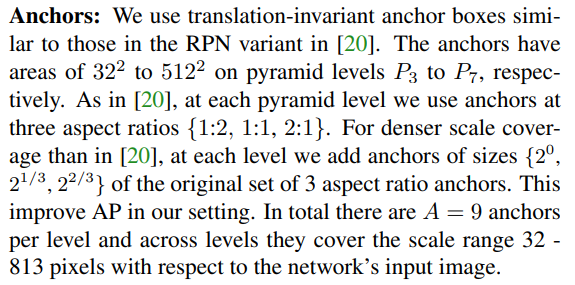

In [ ]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

print('슝=3')

이제 Anchor Box를 생성했으니 입력할 데이터를 Anchor Box에 맞게 변형해줘야 합니다.

데이터 원본의 bbox는 주관식 정답이라고 생각하면 됩니다. 하지만 모델은 객관식으로 문제를 풀어야 하기 때문에 주관식 정답을 가장 가까운 객관식 정답으로 바꿔줘야 모델을 학습시킬 수 있습니다.

그럼 어떻게 주관식 정답을 객관식 정답으로 바꿀 수 있을까요? 여기에서 IoU를 사용합니다.

IoU가 높은지 낮은지에 따라 Anchor Box가 정답인지 오답인지 체크해 두는 것이죠. 그러니 IoU를 계산할 수 있는 함수를 만듭니다.

In [ ]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

print('슝=3')

이제 실제 라벨을 Anchor Box에 맞춰주는 클래스를 만들어 봅시다. 위에서 작성한 compute_iou 함수를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해 줍니다. 그리고 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산합니다. 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록해 둡니다.

이 과정에서 variance가 등장하는데 관례적으로 Anchor Box를 사용할 때 등장합니다.
어디에도 정확한 이유가 등장하지는 않지만 상하좌우의 차이에는 0.1, 가로세로 크기의 차이에는 0.2를 사용합니다.
이와 관련하여 통계적 추정치를 계산할 때 분산으로 나눠주는 것 때문이라는 의견이 있습니다.

이 과정은 마치 데이터를 훈련이 가능한 형식으로 encode하는 것 같으니 LabelEncoder라는 이름으로 클래스를 만들었습니다.

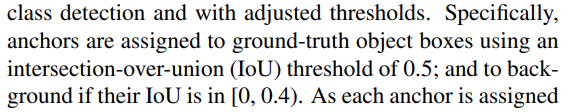


In [ ]:
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()
    
print('슝=3')

이제 데이터를 모델이 학습 가능한 형태로 바꿔 줄 수 있게 되었으니 모델을 만들러 가봅시다.

## 11-6 모델 작성
### Feature Pyramid
앞서 설명했듯이 RetinaNet에서는 FPN(Feature Pyramid Network)를 사용합니다. 완전히 동일한 것은 아니고 약간 수정해서 사용했습니다. 자세한 설명은 아래에 나와있네요.

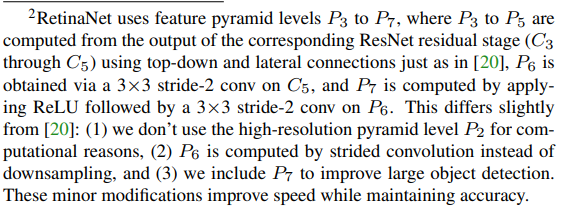



In [ ]:
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

print('슝=3')

Object Detection의 라벨은 class와 box로 이루어지므로 각각을 추론하는 부분이 필요합니다. 그것을 head라고 부르기도 합니다. Backbone에 해당하는 네트워크와 FPN을 통해 pyramid layer가 추출되고 나면 그 feature들을 바탕으로 class를 예상하고, box도 예상합니다. class와 box가 모두 맞을 수도, class와 box 중 하나만 맞을 수도, 둘 다 틀릴 수도 있겠죠? class를 예측하는 head와 box를 예측하는 head가 별도로 존재한다는 것이 중요합니다.

그래서 각각의 head를 만들어 줍니다. head부분은 유사한 형태로 만들 수 있으니 build_head라는 함수를 하나만 만들고 두 번 호출하면 될 것 같네요.

In [ ]:
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

print('슝=3')

우리가 만들 RetinaNet의 backbone은 ResNet50입니다. FPN에 이용할 수 있도록 중간 레이어도 output으로 연결해 줍니다.

In [ ]:
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

print('슝=3')

이제 RetinaNet을 완성해 봅시다. Backbone + FPN + classification용 head + box용 head 입니다.

In [ ]:
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

print('슝=3')

이제 모델을 준비했고, Loss에 대한 준비를 해봅시다.

RetinaNet에서는 Focal Loss를 사용하는데요. Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용됩니다. Box Regression에는 Smooth L1 Loss를 사용했네요.

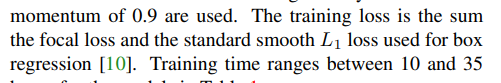

Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고, Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라지는 점에 주의하세요!

In [ ]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

print('슝=3')

이제 모든 준비가 끝났습니다. 모델 학습을 할 수 있겠네요!

## 11-7 모델 학습
앞에서 만들어 놓은 클래스와 함수를 이용해서 모델을 조립하고 학습시켜 봅시다.

In [ ]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

print('슝=3')

모델은 매우 간단하게 만들어 졌네요.

다음으로 Learning Rate입니다. 논문에서는 8개의 GPU를 사용했기 때문에 우리 환경과는 맞지 않아요. 그래서 Learning Rate를 적절히 바꿔줍니다.

Optimizer는 동일하게 SGD를 사용합니다.

In [ ]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

이제 데이터 전처리를 위한 파이프라인도 만들어 줍니다.

In [ ]:
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

print('슝=3')

이제 학습을 시켜봅시다.

1 epoch당 학습 시간이 상당히 오래 걸리기 때문에 여기서는 학습 시키는 예시 코드만 보여드릴게요. (뒤에선 미리 학습된 모델을 불러와 사용할 예정입니다.😙)

In [ ]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 1

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

## 11-8 결과 확인하기
학습된 모델을 불러오자.

In [ ]:
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

print('슝=3')

모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어 줍니다. 논문에서는 1000개의 후보를 골라 처리했지만 우리는 100개의 후보만 골라 처리하도록 합시다. 나머지 설정은 논문과 동일하게 해볼게요.

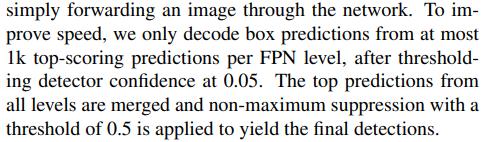

NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 tf.image.combined_non_max_suppression를 사용했습니다.
- tf.image.combined_non_max_suppression

위 참고자료를 꼭 읽어보세요. 입출력되는 값이 어떤지 알아야 코드가 이해가 됩니다. 특히 출력에 nmsed_boxes, nmsed_scores, nmsed_classes, valid_detections이 각각 무엇인지 알아야 활용할 수 있습니다.


In [ ]:
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)

        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

print('슝=3')

이제 추론이 가능한 모델을 조립합니다.

In [ ]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

print('슝=3')

모델의 추론 결과를 시각화 할 함수를 만들어 줍니다.

In [ ]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

print('슝=3')

이제 추론시에 입력 데이터를 전처리하기 위한 함수를 만들게요.

학습을 위한 전처리와 추론을 위한 전처리가 다르기 때문에 따로 작성됩니다. 추론을 위한 전처리가 훨씬 간단하네요.

In [ ]:
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

print('슝=3')

이제 모든 것이 준비 되었으니 학습된 결과를 확인합시다!!

In [ ]:
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )